In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from qpsolvers import *
np.set_printoptions(suppress=True)

In [6]:
# This file contains all the Required functions for the Trajectory control algorithm 
import numpy as np
import matplotlib.pyplot as plt

class SupportFiles:
    

    def __init__(self):
        # All the Constants For the Bi-cycle has been defined in this section 

        g=9.81
        m=1500
        Iz=3000
        Cf=38000
        Cr=66000
        lf=2
        lr=3
        Ts=0.02
        mju=0.02 

        outputs=4 # number of outputs
        inputs=2 # number of inputs
        hz = 10 # horizon period

        trajectory= int(input("Choose any one From the Three trajectories 1,2 or 3 :")) 

        # Initial inputs for x_lim,y_lim and time length 
        x_lim=600
        y_lim=350
        time_length = 0
        delay=0

        

        # The Matrix weights for the Cost function is defined based on the Trajectories

        if trajectory==3:
            # Weights for trajectory 3, version 2
            Q=np.matrix('100 0 0 0;0 20000 0 0;0 0 1000 0;0 0 0 1000') # weights for outputs (all samples, except the last one)
            S=np.matrix('100 0 0 0;0 20000 0 0;0 0 1000 0;0 0 0 1000') # weights for the final horizon period outputs
            R=np.matrix('100 0;0 1') # weights for inputs

        elif trajectory==1:
            # Weights for trajectory 3, version 1
            Q=np.matrix('1 0 0 0;0 200 0 0;0 0 50 0;0 0 0 50') 
            S=np.matrix('1 0 0 0;0 200 0 0;0 0 50 0;0 0 0 50') 
            R=np.matrix('100 0;0 1') 
        else:
            # Weights for trajectory 2
            Q=np.matrix('20000 0 0 0;0 40000 0 0;0 0 20000 0;0 0 0 20000') 
            S=np.matrix('20000 0 0 0;0 40000 0 0;0 0 20000 0;0 0 0 20000') 
            R=np.matrix('200 0;0 20')
        

        # Defining The constants 
        self.constants={'g':g,'m':m,'Iz':Iz,'Cf':Cf,'Cr':Cr,'lf':lf,'lr':lr,\
        'Ts':Ts,'mju':mju,'Q':Q,'S':S,'R':R,'outputs':outputs,'inputs':inputs,\
        'hz':hz,'delay':delay,'time_length':time_length,'trajectory':trajectory,\
        'x_lim':x_lim,'y_lim':y_lim}
        # exit()
        return None
    
    # To Create an Method for Generating refrence Trajectories for the Controller to follow 
    def trajectory_generator(self):

        # Re initiate the Variables 
        Ts=self.constants['Ts']
        trajectory=self.constants['trajectory']
        x_lim=self.constants['x_lim']
        y_lim=self.constants['y_lim']
        time_length=self.constants['time_length']
        delay=self.constants['delay']

        # Define trajectories
        if trajectory==1:

            # Define the Range for the Trajectories 
            time_length = 60.
            x_lim=1000
            y_lim=1000
            
            # Generate the time array 
            t=np.zeros((int(time_length/Ts+1)))

            for i in range(1,len(t)):
                t[i]=np.round(t[i-1]+Ts,2)

            
            Y= 15*t + 150
            X= 750/950**2*Y**2+350

            # Plots
            plt.plot(X,Y,'b',linewidth=2,label='The trajectory')
            plt.xlabel('X-position [m]',fontsize=15)
            plt.ylabel('Y-position [m]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.xlim(0,x_lim)
            plt.ylim(0,y_lim)
            plt.xticks(np.arange(0,x_lim+1,int(x_lim/10)))
            plt.yticks(np.arange(0,y_lim+1,int(y_lim/10)))
            plt.title("The Desired Trajectory",fontsize=12)
            plt.show()
            
            plt.plot(t,X,'b',linewidth=2,label='X ref')
            plt.plot(t,Y,'r',linewidth=2,label='Y ref')
            plt.xlabel('t-position [s]',fontsize=15)
            plt.ylabel('X,Y-position [m]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.xlim(0,t[-1])
            plt.title("X_ref,Y_ref compared with time(ts)",fontsize=12)
            plt.show()
            #exit()

            # Vector of x and y changes per sample time
            dX=X[1:len(X)]-X[0:len(X)-1]
            dY=Y[1:len(Y)]-Y[0:len(Y)-1]

            X_dot=dX/Ts
            Y_dot=dY/Ts
            X_dot=np.concatenate(([X_dot[0]],X_dot),axis=0)
            Y_dot=np.concatenate(([Y_dot[0]],Y_dot),axis=0)

            # Define the reference yaw angles
            psi=np.zeros(len(X))
            psiInt=psi
            psi[0]=np.arctan2(dY[0],dX[0])
            psi[1:len(psi)]=np.arctan2(dY[0:len(dY)],dX[0:len(dX)])

            # The yaw angle needs to keep track of the rotations
            dpsi=psi[1:len(psi)]-psi[0:len(psi)-1]
            psiInt[0]=psi[0]
            for i in range(1,len(psiInt)):
                if dpsi[i-1]<-np.pi:
                    psiInt[i]=psiInt[i-1]+(dpsi[i-1]+2*np.pi)
                elif dpsi[i-1]>np.pi:
                    psiInt[i]=psiInt[i-1]+(dpsi[i-1]-2*np.pi)
                else:
                    psiInt[i]=psiInt[i-1]+dpsi[i-1]


            x_dot_body=np.cos(psiInt)*X_dot+np.sin(psiInt)*Y_dot
            y_dot_body=-np.sin(psiInt)*X_dot+np.cos(psiInt)*Y_dot
            y_dot_body=np.round(y_dot_body)

            # Plot the body frame velocity
            plt.plot(t,X_dot,'b',linewidth=2,label='X_dot ref')
            plt.plot(t,Y_dot,'r',linewidth=2,label='Y_dot ref')
            plt.xlabel('t [s]',fontsize=15)
            plt.ylabel('X_dot_ref, Y_dot_ref [m/s]',fontsize=12)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.title("Body Frame Velocity" ,fontsize=12)
            plt.show()
            
            # Plot the reference yaw angle
            plt.plot(t,psiInt,'g',linewidth=2,label='Psi ref')
            plt.xlabel('t [s]',fontsize=15)
            plt.ylabel('Psi_ref [rad]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.title("Rference Yaw angles",fontsize=12)
            plt.show()
            #exit()


        elif trajectory==2:
            # Initialize the Parameters 
            x_lim=600
            y_lim=350
            t=[]
            x_dot_body=[]
            psiInt=[]
            X=[]
            Y=[]

            x_dot_body_i_1=2
            x_dot_body_f_1=5
            x_dot_body_max_1=30
            psiInt_i_1=0
            delta_t_increase_1=7
            delta_t_decrease_1=10
            X_i_1=50
            X_slow_down_1=270
            X_f_1=450
            Y_i_1=0

            x_dot_body=np.append(x_dot_body,x_dot_body_i_1)
            psiInt=np.append(psiInt,psiInt_i_1)
            X=np.append(X,X_i_1)
            Y=np.append(Y,Y_i_1)
            t=np.append(t,0)

            A_increase_1=(x_dot_body_max_1-x_dot_body_i_1)/2
            f_increase_1=1/(2*delta_t_increase_1)
            C_increase_1=A_increase_1+x_dot_body_i_1
            while x_dot_body[-1] < x_dot_body_max_1:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,A_increase_1*np.sin(2*np.pi*f_increase_1*(t[-1]-delta_t_increase_1/2))+C_increase_1)
                psiInt=np.append(psiInt,0)
                X=np.append(X,X[-1]+x_dot_body[-1]*Ts)
                Y=np.append(Y,0)

            while X[-1]<=X_slow_down_1:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body_max_1)
                psiInt=np.append(psiInt,0)
                X=np.append(X,X[-1]+x_dot_body[-1]*Ts)
                Y=np.append(Y,0)

            t_temp_1=t[-1]
            A_decrease_1=(x_dot_body_max_1-x_dot_body_f_1)/2
            f_decrease_1=1/(2*delta_t_decrease_1)
            C_decrease_1=A_decrease_1+x_dot_body_f_1

            while x_dot_body[-1] > x_dot_body_f_1:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,A_decrease_1*np.cos(2*np.pi*f_decrease_1*(t[-1]-t_temp_1))+C_decrease_1)
                psiInt=np.append(psiInt,0)
                X=np.append(X,X[-1]+x_dot_body[-1]*Ts)
                Y=np.append(Y,0)

            while X[-1]<X_f_1:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body_f_1)
                psiInt=np.append(psiInt,0)
                X=np.append(X,X[-1]+x_dot_body[-1]*Ts)
                Y=np.append(Y,0)


            # Section 2
            turn_radius_2=50
            turn_angle_2=np.pi/2
            final_Y_2=100

            turn_distance_2=turn_angle_2*turn_radius_2
            turn_time_2=turn_distance_2/x_dot_body[-1]
            angular_velocity_2=turn_angle_2/turn_time_2

            while psiInt[-1]<turn_angle_2:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1])
                psiInt=np.append(psiInt,psiInt[-1]+angular_velocity_2*Ts)
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)
                

            while Y[-1]<final_Y_2:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1])
                psiInt=np.append(psiInt,psiInt[-1])
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)
            t_temp_2=t[-1]


            # Section 3
            turn_radius_3=25
            turn_angle_3=np.pi/2
            x_dot_body_i_3=5
            x_dot_body_f_3=10
            delta_t_increase_3=5.24
            X_f_3=450


            turn_distance_3=turn_angle_3*turn_radius_3
            A_increase_3=(x_dot_body_f_3-x_dot_body_i_3)/2
            f_increase_3=1/(2*delta_t_increase_3)
            C_increase_3=A_increase_3+x_dot_body_i_3


            while psiInt[-1]<=turn_angle_2+turn_angle_3:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,A_increase_3*np.sin(2*np.pi*f_increase_3*(t[-1]-delta_t_increase_3/2-t_temp_2))+C_increase_3)
                psiInt=np.append(psiInt,psiInt[-1]+x_dot_body[-1]/turn_radius_3*Ts)
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)

            while X[-1]>X_f_3:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1])
                psiInt=np.append(psiInt,psiInt[-1])
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)
            t_temp_3=t[-1]

            # Section 4
            turn_radius_4=50
            turn_angle_4=-np.pi
            x_dot_body_i_4=10
            x_dot_body_f_4=15
            delta_t_increase_4=12.60

            turn_distance_4=turn_angle_4*turn_radius_4
            A_increase_4=(x_dot_body_f_4-x_dot_body_i_4)/2
            f_increase_4=1/(2*delta_t_increase_4)
            C_increase_4=A_increase_4+x_dot_body_i_4


            while psiInt[-1]>=turn_angle_2+turn_angle_3+turn_angle_4:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,A_increase_4*np.sin(2*np.pi*f_increase_4*(t[-1]-delta_t_increase_4/2-t_temp_3))+C_increase_4)
                psiInt=np.append(psiInt,psiInt[-1]-x_dot_body[-1]/turn_radius_4*Ts)
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)
            t_temp_4=t[-1]


            # Section 5
            turn_radius_5=50
            turn_angle_5=np.pi
            x_dot_body_i_5=15
            x_dot_body_f_5=25
            delta_t_increase_5=7.88
            X_f_5=200

            turn_distance_5=turn_angle_5*turn_radius_5
            A_increase_5=(x_dot_body_f_5-x_dot_body_i_5)/2
            f_increase_5=1/(2*delta_t_increase_5)
            C_increase_5=A_increase_5+x_dot_body_i_5


            while psiInt[-1]<=turn_angle_2+turn_angle_3+turn_angle_4+turn_angle_5:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,A_increase_5*np.sin(2*np.pi*f_increase_5*(t[-1]-delta_t_increase_5/2-t_temp_4))+C_increase_5)
                psiInt=np.append(psiInt,psiInt[-1]+x_dot_body[-1]/turn_radius_5*Ts)
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)

            while X[-1]>X_f_5:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1])
                psiInt=np.append(psiInt,psiInt[-1])
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)


            # Section 6
            x_dot_body_i_6=25
            x_dot_body_f_6=3
            delta_t_increase_6=8
            x_dot_slope_6=(x_dot_body_f_6-x_dot_body_i_6)/delta_t_increase_6
            while x_dot_body[-1]>x_dot_body_f_6:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1]+x_dot_slope_6*Ts)
                psiInt=np.append(psiInt,psiInt[-1])
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)


            X_f_6=80
            while X[-1]>X_f_6:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1])
                psiInt=np.append(psiInt,psiInt[-1])
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)
            t_temp_6=t[-1]

            # Section 7
            turn_radius_7=15
            turn_angle_7=np.pi/2
            x_dot_body_f_7=30
            final_Y_7=-70

            turn_distance_7=turn_angle_7*turn_radius_7
            turn_time_7=turn_distance_7/x_dot_body[-1]
            angular_velocity_7=turn_angle_7/turn_time_7
            car_acceleration_7=3

            while psiInt[-1]<turn_angle_2+turn_angle_3+turn_angle_4+turn_angle_5+turn_angle_7:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1])
                psiInt=np.append(psiInt,psiInt[-1]+angular_velocity_7*Ts)
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)

            while Y[-1]>=300:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1])
                psiInt=np.append(psiInt,psiInt[-1])
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)

            while x_dot_body[-1]<x_dot_body_f_7:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1]+car_acceleration_7*Ts)
                psiInt=np.append(psiInt,psiInt[-1])
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)

            while Y[-1]>=final_Y_7:
                t=np.append(t,t[-1]+Ts)
                x_dot_body=np.append(x_dot_body,x_dot_body[-1])
                psiInt=np.append(psiInt,psiInt[-1])
                X=np.append(X,X[-1]+x_dot_body[-1]*np.cos(psiInt[-1])*Ts)
                Y=np.append(Y,Y[-1]+x_dot_body[-1]*np.sin(psiInt[-1])*Ts)

            y_dot_body=np.zeros(len(t))

 

            # print(t)
            # print(x_dot_body)
            # print(psiInt)
            # print(X)
            # print(Y)
            # exit()
            
            
            # Plots
            plt.plot(X,Y,'b',linewidth=2,label='The trajectory')
            plt.xlabel('X-position [m]',fontsize=15)
            plt.ylabel('Y-position [m]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.xlim(0,x_lim)
            plt.ylim(-50,y_lim)
            plt.xticks(np.arange(0,x_lim+1,int(x_lim/10)))
            plt.yticks(np.arange(-50,y_lim+1,int(y_lim/10)))
            plt.title("The Desired Trajectory",fontsize=12)
            plt.show()
            
            plt.plot(t,X,'b',linewidth=2,label='X ref')
            plt.plot(t,Y,'r',linewidth=2,label='Y ref')
            plt.xlabel('t-position [s]',fontsize=15)
            plt.ylabel('X,Y-position [m]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.xlim(0,t[-1])
            plt.title("X_ref,Y_ref compared with time(ts)",fontsize=12)
            plt.show()
            # exit()
            
            
            # Plot the body frame velocity
            plt.plot(t,x_dot_body,'g',linewidth=2,label='x_dot ref')
            plt.xlabel('t [s]',fontsize=15)
            plt.ylabel('X_dot_ref, Y_dot_ref [m/s]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.title("Bodyframe velocities")
            plt.show()

            # Plot the reference yaw angle
            plt.plot(t,psiInt,'g',linewidth=2,label='Psi ref')
            plt.xlabel('t [s]',fontsize=15)
            plt.ylabel('Psi_ref [rad]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.title("Reference Yaw angles",fontsize=12)
            plt.show()
            #exit()


           
        else:

            # 3rd Trajectory

            # Initializing the Parameters 
            x_lim=170*2
            y_lim=160*2
            first_section=14
            other_sections=14
            time_length=first_section+other_sections*10

            delay=np.zeros(12)
            for dly in range(1,len(delay)):
                delay[dly]=first_section+(dly-1)*other_sections
            print(delay)

            t=np.zeros((int(time_length/Ts+1)))

            for i in range(1,len(t)):
                t[i]=np.round(t[i-1]+Ts,2)

            # X & Y levels
            f_x=np.array([0,60,110,140,160,110,40,10,40,70,110,150])*2
            f_y=np.array([40,20,20,60,100,140,140,80,60,60,90,90])*2

            # X & Y derivatives
            f_x_dot=np.array([2,1,1,1,0,-1,-1,0,1,1,1,1])*3*2
            f_y_dot=np.array([0,0,0,1,1,0,0,-1,0,0,0,0])*3*2


            X=[]
            Y=[]
            for i in range(0,len(delay)-1):
                if i != len(delay)-2:
                    t_temp=t[int(delay[i]/Ts):int(delay[i+1]/Ts)]
                else:
                    t_temp=t[int(delay[i]/Ts):int(delay[i+1]/Ts+1)]

                # Generate data for a subtrajectory
                M=np.array([[1,t_temp[0],t_temp[0]**2,t_temp[0]**3],\
                            [1,t_temp[-1],t_temp[-1]**2,t_temp[-1]**3],\
                            [0,1,2*t_temp[0],3*t_temp[0]**2],\
                            [0,1,2*t_temp[-1],3*t_temp[-1]**2]])

                c_x=np.array([[f_x[i]],[f_x[i+1]-f_x_dot[i+1]*Ts],[f_x_dot[i]],[f_x_dot[i+1]]])
                c_y=np.array([[f_y[i]],[f_y[i+1]-f_y_dot[i+1]*Ts],[f_y_dot[i]],[f_y_dot[i+1]]])


                a_x=np.matmul(np.linalg.inv(M),c_x)
                a_y=np.matmul(np.linalg.inv(M),c_y)

                # Compute X and Y values
                X_temp=a_x[0][0]+a_x[1][0]*t_temp+a_x[2][0]*t_temp**2+a_x[3][0]*t_temp**3
                Y_temp=a_y[0][0]+a_y[1][0]*t_temp+a_y[2][0]*t_temp**2+a_y[3][0]*t_temp**3

                # Concatenate X and Y values
                X=np.concatenate([X,X_temp])
                Y=np.concatenate([Y,Y_temp])

            # Round the numbers to avoid numerical errors
            X=np.round(X,8)
            Y=np.round(Y,8)

            # Plots
            plt.subplots_adjust(left=0.05,bottom=0.05,right=0.95,top=0.95,wspace=0.15,hspace=0.2)
            plt.plot(X,Y,'b',linewidth=2,label='The ref trajectory')
            plt.xlabel('X-position [m]',fontsize=15)
            plt.ylabel('Y-position [m]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.xlim(0,x_lim)
            plt.ylim(0,y_lim)
            plt.xticks(np.arange(0,x_lim+1,int(x_lim/10)))
            plt.yticks(np.arange(0,y_lim+1,int(y_lim/10)))
            plt.title("The Desired Trajectory",fontsize=12)
            plt.show()
            
            plt.subplots_adjust(left=0.05,bottom=0.05,right=0.95,top=0.95,wspace=0.15,hspace=0.2)
            plt.plot(t,X,'b',linewidth=2,label='X ref')
            plt.plot(t,Y,'r',linewidth=2,label='Y ref')
            plt.xlabel('t-position [s]',fontsize=15)
            plt.ylabel('X,Y-position [m]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.xlim(0,t[-1])
            plt.title("X and Y positions with respect to time ",fontsize=12)
            plt.show()
            # exit()

            # Vector of x and y changes per sample time
            dX=X[1:len(X)]-X[0:len(X)-1]
            dY=Y[1:len(Y)]-Y[0:len(Y)-1]

            X_dot=dX/Ts
            Y_dot=dY/Ts
            X_dot=np.concatenate(([X_dot[0]],X_dot),axis=0)
            Y_dot=np.concatenate(([Y_dot[0]],Y_dot),axis=0)

            # Define the reference yaw angles
            psi=np.zeros(len(X))
            psiInt=psi
            psi[0]=np.arctan2(dY[0],dX[0])
            psi[1:len(psi)]=np.arctan2(dY[0:len(dY)],dX[0:len(dX)])

            # We want the yaw angle to keep track the amount of rotations
            dpsi=psi[1:len(psi)]-psi[0:len(psi)-1]
            psiInt[0]=psi[0]
            for i in range(1,len(psiInt)):
                if dpsi[i-1]<-np.pi:
                    psiInt[i]=psiInt[i-1]+(dpsi[i-1]+2*np.pi)
                elif dpsi[i-1]>np.pi:
                    psiInt[i]=psiInt[i-1]+(dpsi[i-1]-2*np.pi)
                else:
                    psiInt[i]=psiInt[i-1]+dpsi[i-1]


            x_dot_body=np.cos(psiInt)*X_dot+np.sin(psiInt)*Y_dot
            y_dot_body=-np.sin(psiInt)*X_dot+np.cos(psiInt)*Y_dot
            y_dot_body=np.round(y_dot_body)

            # Plot the body frame velocity
            plt.plot(t,X_dot,'b',linewidth=2,label='X_dot ref')
            plt.plot(t,Y_dot,'r',linewidth=2,label='Y_dot ref')
            plt.xlabel('t [s]',fontsize=15)
            plt.ylabel('X_dot_ref, Y_dot_ref [m/s]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.title("Bady frame velocities with respect to time",fontsize=12)
            plt.show()
            
            # Plot the reference yaw angle
            plt.plot(t,psiInt,'g',linewidth=2,label='Psi ref')
            plt.xlabel('t [s]',fontsize=15)
            plt.ylabel('Psi_ref [rad]',fontsize=15)
            plt.grid(True)
            plt.legend(loc='upper right',fontsize='small')
            plt.title("Refrence Yaw angles with respect to time",fontsize=12)
            plt.show()
            #exit()

        return x_dot_body,y_dot_body,psiInt,X,Y,t

    def state_space(self,states,delta,a):

       # Define the Required Constants 
        g=self.constants['g']
        m=self.constants['m']
        Iz=self.constants['Iz']
        Cf=self.constants['Cf']
        Cr=self.constants['Cr']
        lf=self.constants['lf']
        lr=self.constants['lr']
        Ts=self.constants['Ts']
        mju=self.constants['mju']

        # Get the necessary states
        x_dot=states[0]
        y_dot=states[1]
        psi=states[2]

        # Get the state space matrices for the control
        A11=-mju*g/x_dot
        A12=Cf*np.sin(delta)/(m*x_dot)
        A14=Cf*lf*np.sin(delta)/(m*x_dot)+y_dot
        A22=-(Cr+Cf*np.cos(delta))/(m*x_dot)
        A24=-(Cf*lf*np.cos(delta)-Cr*lr)/(m*x_dot)-x_dot
        A34=1
        A42=-(Cf*lf*np.cos(delta)-lr*Cr)/(Iz*x_dot)
        A44=-(Cf*lf**2*np.cos(delta)+lr**2*Cr)/(Iz*x_dot)
        A51=np.cos(psi)
        A52=-np.sin(psi)
        A61=np.sin(psi)
        A62=np.cos(psi)

        B11=-1/m*np.sin(delta)*Cf
        B12=1
        B21=1/m*np.cos(delta)*Cf
        B41=1/Iz*np.cos(delta)*Cf*lf

        # Define The State Space Matrices
        A=np.array([[A11, A12, 0, A14, 0, 0],[0, A22, 0, A24, 0, 0],[0, 0, 0, A34, 0, 0],\
        [0, A42, 0, A44, 0, 0],[A51, A52, 0, 0, 0, 0],[A61, A62, 0, 0, 0, 0]])
        B=np.array([[B11, B12],[B21, 0],[0, 0],[B41, 0],[0, 0],[0, 0]])
        C=np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0],[0, 0, 0, 0, 1, 0],[0, 0, 0, 0, 0, 1]])
        D=np.array([[0, 0],[0, 0],[0, 0],[0, 0]])

        # Discretise the system (forward Euler)
        Ad=np.identity(np.size(A,1))+Ts*A
        Bd=Ts*B
        Cd=C
        Dd=D

        return Ad, Bd, Cd, Dd

    def augmented_matrices(self, Ad, Bd, Cd, Dd):

        A_aug=np.concatenate((Ad,Bd),axis=1)
        temp1=np.zeros((np.size(Bd,1),np.size(Ad,1)))
        temp2=np.identity(np.size(Bd,1))
        temp=np.concatenate((temp1,temp2),axis=1)

        A_aug=np.concatenate((A_aug,temp),axis=0)
        B_aug=np.concatenate((Bd,np.identity(np.size(Bd,1))),axis=0)
        C_aug=np.concatenate((Cd,np.zeros((np.size(Cd,0),np.size(Bd,1)))),axis=1)
        D_aug=Dd

        return A_aug, B_aug, C_aug, D_aug
    
    # Method to calculate the Matrices for the Mpc Controller 
     
    def mpc_simplification(self, Ad, Bd, Cd, Dd, hz, x_aug_t, du, ii):

        # db - double bar
        # dbt - double bar transpose
        # dc - double circumflex

        A_aug, B_aug, C_aug, D_aug=self.augmented_matrices(Ad, Bd, Cd, Dd)

        Q=self.constants['Q']
        S=self.constants['S']
        R=self.constants['R']
        Cf=self.constants['Cf']
        g=self.constants['g']
        m=self.constants['m']
        mju=self.constants['mju']
        lf=self.constants['lf']
        inputs=self.constants['inputs']

        if ii>=2750:
            Q[1,1]=400000
            S[1,1]=400000

        #Constraints
        d_delta_max=np.pi/300
        d_a_max=0.1
        d_delta_min=-np.pi/300
        d_a_min=-0.1

        ub_global=np.zeros(inputs*hz)
        lb_global=np.zeros(inputs*hz)

        # Only works for 2 inputs
        for i in range(0,inputs*hz):
            if i%2==0:
                ub_global[i]=d_delta_max
                lb_global[i]=-d_delta_min
            else:
                ub_global[i]=d_a_max
                lb_global[i]=-d_a_min

        ub_global=ub_global[0:inputs*hz]
        lb_global=lb_global[0:inputs*hz]
        ublb_global=np.concatenate((ub_global,lb_global),axis=0)

        I_global=np.eye(inputs*hz)
        I_global_negative=-I_global
        I_mega_global=np.concatenate((I_global,I_global_negative),axis=0)

        y_asterisk_max_global=[]
        y_asterisk_min_global=[]

        C_asterisk=np.matrix('1 0 0 0 0 0 0 0;\
                        0 1 0 0 0 0 0 0;\
                        0 0 0 0 0 0 1 0;\
                        0 0 0 0 0 0 0 1')

        C_asterisk_global=np.zeros((np.size(C_asterisk,0)*hz,np.size(C_asterisk,1)*hz))

        CQC=np.matmul(np.transpose(C_aug),Q)
        CQC=np.matmul(CQC,C_aug)

        CSC=np.matmul(np.transpose(C_aug),S)
        CSC=np.matmul(CSC,C_aug)

        QC=np.matmul(Q,C_aug)
        SC=np.matmul(S,C_aug)

        Qdb=np.zeros((np.size(CQC,0)*hz,np.size(CQC,1)*hz))
        Tdb=np.zeros((np.size(QC,0)*hz,np.size(QC,1)*hz))
        Rdb=np.zeros((np.size(R,0)*hz,np.size(R,1)*hz))
        Cdb=np.zeros((np.size(B_aug,0)*hz,np.size(B_aug,1)*hz))
        Adc=np.zeros((np.size(A_aug,0)*hz,np.size(A_aug,1)))

        #Lpv Model
        A_product=A_aug
        states_predicted_aug=x_aug_t
        A_aug_collection=np.zeros((hz,np.size(A_aug,0),np.size(A_aug,1)))
        B_aug_collection=np.zeros((hz,np.size(B_aug,0),np.size(B_aug,1)))
        

        for i in range(0,hz):
            if i == hz-1:
                Qdb[np.size(CSC,0)*i:np.size(CSC,0)*i+CSC.shape[0],np.size(CSC,1)*i:np.size(CSC,1)*i+CSC.shape[1]]=CSC
                Tdb[np.size(SC,0)*i:np.size(SC,0)*i+SC.shape[0],np.size(SC,1)*i:np.size(SC,1)*i+SC.shape[1]]=SC
            else:
                Qdb[np.size(CQC,0)*i:np.size(CQC,0)*i+CQC.shape[0],np.size(CQC,1)*i:np.size(CQC,1)*i+CQC.shape[1]]=CQC
                Tdb[np.size(QC,0)*i:np.size(QC,0)*i+QC.shape[0],np.size(QC,1)*i:np.size(QC,1)*i+QC.shape[1]]=QC

            Rdb[np.size(R,0)*i:np.size(R,0)*i+R.shape[0],np.size(R,1)*i:np.size(R,1)*i+R.shape[1]]=R

            # LPV Model
            Adc[np.size(A_aug,0)*i:np.size(A_aug,0)*i+A_aug.shape[0],0:0+A_aug.shape[1]]=A_product
            A_aug_collection[i][:][:]=A_aug
            B_aug_collection[i][:][:]=B_aug
            

            # Constraints
            x_dot_max=40
            if 0.17*states_predicted_aug[0][0] < 3:
                y_dot_max=0.17*states_predicted_aug[0][0]
            else:
                y_dot_max=3
            delta_max=np.pi/6
            Fyf=Cf*(states_predicted_aug[6][0]-states_predicted_aug[1][0]/states_predicted_aug[0][0]-lf*states_predicted_aug[3][0]/states_predicted_aug[0][0])
            a_max=10+(Fyf*np.sin(states_predicted_aug[6][0])+mju*m*g)/m-states_predicted_aug[3][0]*states_predicted_aug[1][0]
            x_dot_min=1
            if -0.17*states_predicted_aug[0][0] > -3:
                y_dot_min=-0.17*states_predicted_aug[0][0]
            else:
                y_dot_min=-3
            delta_min=-np.pi/6
            a_min=-5+(Fyf*np.sin(states_predicted_aug[6][0])+mju*m*g)/m-states_predicted_aug[3][0]*states_predicted_aug[1][0]

            y_asterisk_max=np.array([x_dot_max,y_dot_max,delta_max,a_max])
            y_asterisk_min=np.array([x_dot_min,y_dot_min,delta_min,a_min])

            y_asterisk_max_global=np.concatenate((y_asterisk_max_global,y_asterisk_max),axis=0)
            y_asterisk_min_global=np.concatenate((y_asterisk_min_global,y_asterisk_min),axis=0)

            C_asterisk_global[np.size(C_asterisk,0)*i:np.size(C_asterisk,0)*i+C_asterisk.shape[0],np.size(C_asterisk,1)*i:np.size(C_asterisk,1)*i+C_asterisk.shape[1]]=C_asterisk


            
           #LPV
            if i<hz-1:
                du1=du[inputs*(i+1)][0]
                du2=du[inputs*(i+1)+inputs-1][0]
                states_predicted_aug=np.matmul(A_aug,states_predicted_aug)+np.matmul(B_aug,np.transpose([[du1,du2]]))
                states_predicted=np.transpose(states_predicted_aug[0:6])[0]
                delta_predicted=states_predicted_aug[6][0]
                a_predicted=states_predicted_aug[7][0]
                Ad, Bd, Cd, Dd=self.state_space(states_predicted,delta_predicted,a_predicted)
                A_aug, B_aug, C_aug, D_aug=self.augmented_matrices(Ad, Bd, Cd, Dd)
                A_product=np.matmul(A_aug,A_product)

        for i in range(0,hz):
            for j in range(0,hz):
                if j<=i:
                    AB_product=np.eye(np.shape(A_aug)[0])
                    for ii in range(i,j-1,-1):
                        if ii>j:
                            AB_product=np.matmul(AB_product,A_aug_collection[ii][:][:])
                        else:
                            AB_product=np.matmul(AB_product,B_aug_collection[ii][:][:])
                    Cdb[np.size(B_aug,0)*i:np.size(B_aug,0)*i+B_aug.shape[0],np.size(B_aug,1)*j:np.size(B_aug,1)*j+B_aug.shape[1]]=AB_product

       

        #Constraints for the controller

        Cdb_constraints=np.matmul(C_asterisk_global,Cdb)
        Cdb_constraints_negative=-Cdb_constraints
        Cdb_constraints_global=np.concatenate((Cdb_constraints,Cdb_constraints_negative),axis=0)

        Adc_constraints=np.matmul(C_asterisk_global,Adc)
        Adc_constraints_x0=np.transpose(np.matmul(Adc_constraints,x_aug_t))[0]
        y_max_Adc_difference=y_asterisk_max_global-Adc_constraints_x0
        y_min_Adc_difference=-y_asterisk_min_global+Adc_constraints_x0
        y_Adc_difference_global=np.concatenate((y_max_Adc_difference,y_min_Adc_difference),axis=0)

        G=np.concatenate((I_mega_global,Cdb_constraints_global),axis=0)
        ht=np.concatenate((ublb_global,y_Adc_difference_global),axis=0)
        Hdb=np.matmul(np.transpose(Cdb),Qdb)
        Hdb=np.matmul(Hdb,Cdb)+Rdb

        temp=np.matmul(np.transpose(Adc),Qdb)
        temp=np.matmul(temp,Cdb)

        temp2=np.matmul(-Tdb,Cdb)
        Fdbt=np.concatenate((temp,temp2),axis=0)

        return Hdb,Fdbt,Cdb,Adc,G,ht

    def open_loop_new_states(self,states,delta,a):
        

        # Define The Necessary Constants 
        g=self.constants['g']
        m=self.constants['m']
        Iz=self.constants['Iz']
        Cf=self.constants['Cf']
        Cr=self.constants['Cr']
        lf=self.constants['lf']
        lr=self.constants['lr']
        Ts=self.constants['Ts']
        mju=self.constants['mju']

        current_states=states
        new_states=current_states
        x_dot=current_states[0]
        y_dot=current_states[1]
        psi=current_states[2]
        psi_dot=current_states[3]
        X=current_states[4]
        Y=current_states[5]
        
        # Divde the loop into smaller pieces
        sub_loop=30  
        for i in range(0,sub_loop):

            # Compute lateral forces
            Fyf=Cf*(delta-y_dot/x_dot-lf*psi_dot/x_dot)
            Fyr=Cr*(-y_dot/x_dot+lr*psi_dot/x_dot)

            # Compute the the derivatives of the states
            x_dot_dot=a+(-Fyf*np.sin(delta)-mju*m*g)/m+psi_dot*y_dot
            y_dot_dot=(Fyf*np.cos(delta)+Fyr)/m-psi_dot*x_dot
            psi_dot=psi_dot
            psi_dot_dot=(Fyf*lf*np.cos(delta)-Fyr*lr)/Iz
            X_dot=x_dot*np.cos(psi)-y_dot*np.sin(psi)
            Y_dot=x_dot*np.sin(psi)+y_dot*np.cos(psi)

            # Update the state values with new state derivatives
            x_dot=x_dot+x_dot_dot*Ts/sub_loop
            y_dot=y_dot+y_dot_dot*Ts/sub_loop
            psi=psi+psi_dot*Ts/sub_loop
            psi_dot=psi_dot+psi_dot_dot*Ts/sub_loop
            X=X+X_dot*Ts/sub_loop
            Y=Y+Y_dot*Ts/sub_loop

        # Take the last states
        new_states[0]=x_dot
        new_states[1]=y_dot
        new_states[2]=psi
        new_states[3]=psi_dot
        new_states[4]=X
        new_states[5]=Y

        return new_states,x_dot_dot,y_dot_dot,psi_dot_dot


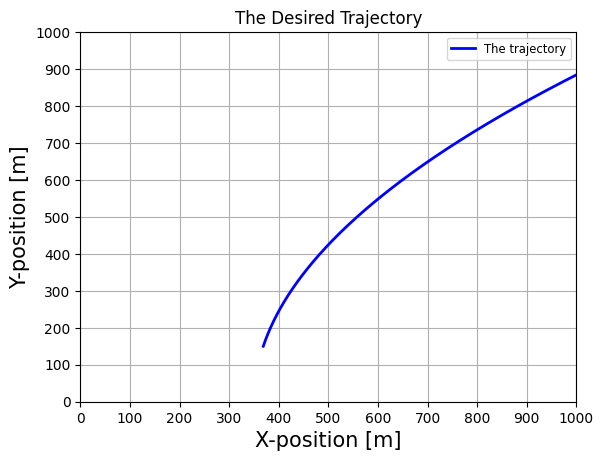

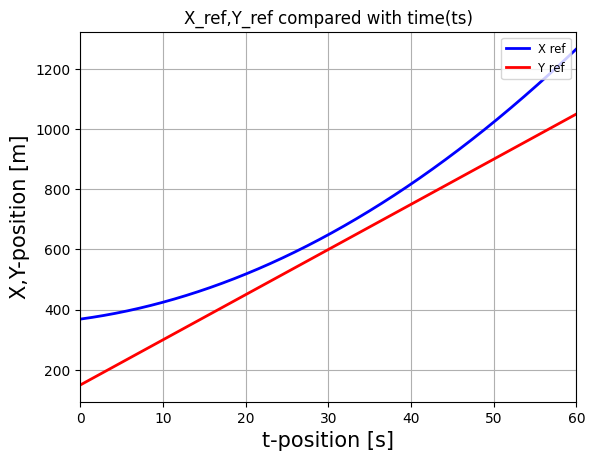

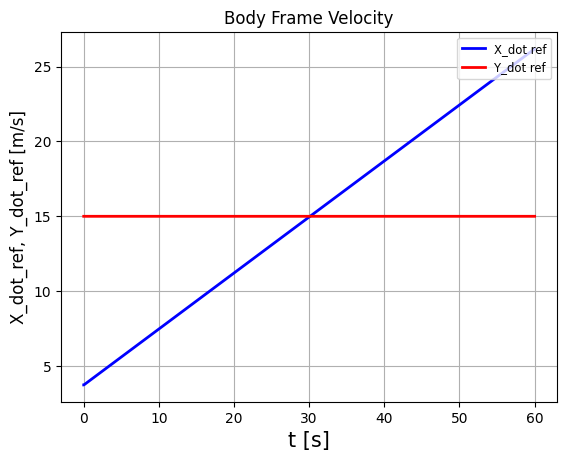

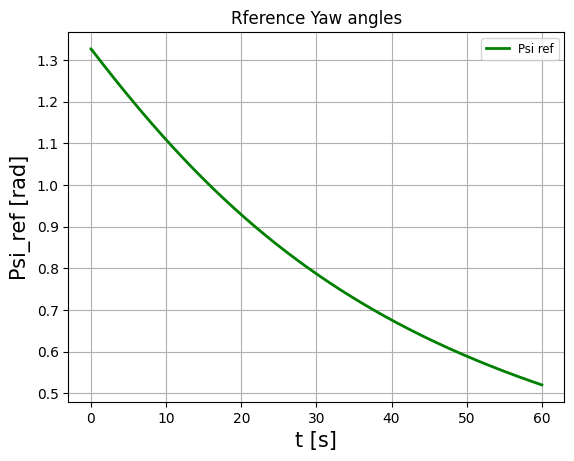

Loading: ######### 0.0%
Loading: ######### 16.66%
Loading: ######### 33.32%
Loading: ######### 49.98%
Loading: ######### 66.64%
Loading: ######### 83.31%


ValueError: Image size of 2007x-1644965002 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1920x1080 with 6 Axes>

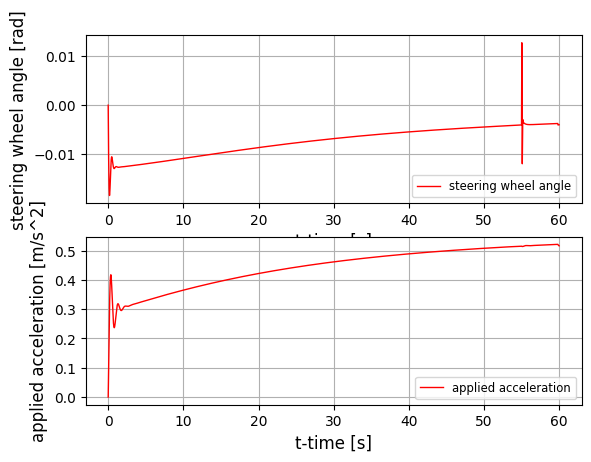

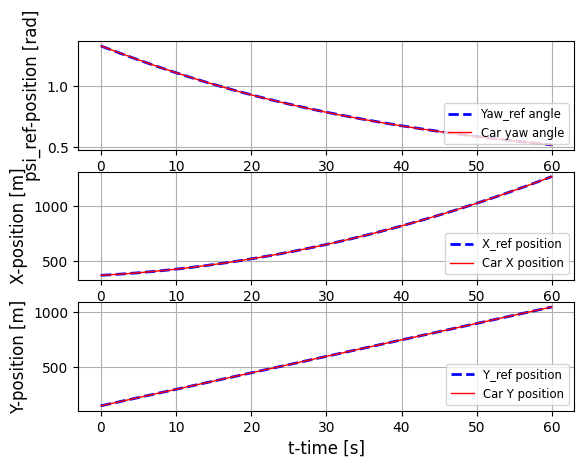

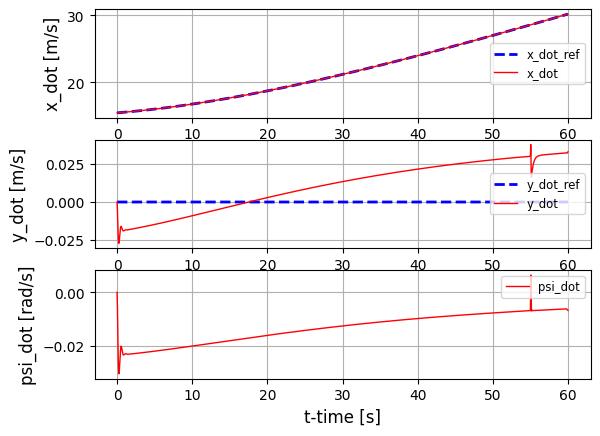

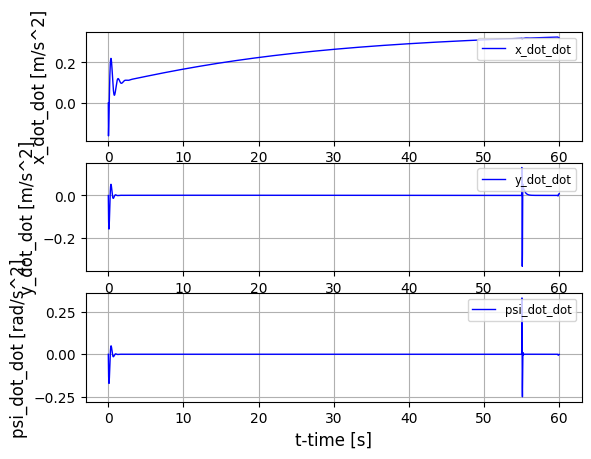

: 

In [7]:
#MPC Controller for a Automated car (bi-cycle model)
#Import the Necessary libraries for the code 
import numpy as np
import matplotlib.pyplot as plt
import support_files as sp_files
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from qpsolvers import *
np.set_printoptions(suppress=True)

 
support= SupportFiles()
constants=support.constants

# Load the constant values needed in the main file
Ts=constants['Ts']
outputs=constants['outputs'] 
hz = constants['hz'] # horizon prediction period
inputs=constants['inputs']
x_lim=constants['x_lim']
y_lim=constants['y_lim']
trajectory=constants['trajectory']



x_dot_ref,y_dot_ref,psi_ref,X_ref,Y_ref,t=support.trajectory_generator()
sim_length=len(t) # Number of control loop iterations
refSignals=np.zeros(len(X_ref)*outputs)

# Build up the reference signal vector:
#Vector contains all the outputs 
k=0
for i in range(0,len(refSignals),outputs):
    refSignals[i]=x_dot_ref[k]
    refSignals[i+1]=psi_ref[k]
    refSignals[i+2]=X_ref[k]
    refSignals[i+3]=Y_ref[k]
    k=k+1

# Load the initial states
# initial staes are same as the reference states 

x_dot=x_dot_ref[0]
y_dot=y_dot_ref[0]
psi=psi_ref[0]
psi_dot=0.
X=X_ref[0]
Y=Y_ref[0]

states=np.array([x_dot,y_dot,psi,psi_dot,X,Y])
statesTotal=np.zeros((len(t),len(states))) 
statesTotal[0][0:len(states)]=states

#Acceleration
x_dot_dot=0.
y_dot_dot=0.
psi_dot_dot=0.

accelerations=np.array([x_dot_dot,y_dot_dot,psi_dot_dot])
accelerations_total=np.zeros((len(t),len(accelerations)))



# Load the initial input
# Input at t = -0.02 s (steering wheel angle in rad (delta) and acceleration in m/s^2 (a))
U1=0 
U2=0 
UTotal=np.zeros((len(t),2)) 
UTotal[0][0]=U1
UTotal[0][1]=U2

# Initiate the controller - simulation loops
k=0
du=np.zeros((inputs*hz,1))


# Arrays for the animation
t_ani=[]
x_dot_ani=[]
psi_ani=[]
X_ani=[]
Y_ani=[]
delta_ani=[]

for i in range(0,sim_length-1):

    # Generate the discrete state space matrices
    Ad,Bd,Cd,Dd=support.state_space(states,U1,U2)

    # Generate the augmented current state and the reference vector
    x_aug_t=np.transpose([np.concatenate((states,[U1,U2]),axis=0)])

    # From the refSignals vector, we only extract the reference values from  [current sample (NOW) + Ts] to [NOW+horizon period (hz)]
    # Example: Ts=0.1 seconds, t_now is 3 seconds, hz = 15 , so from refSignals vectors, you move the elements to vector r:
    # r=[x_dot_ref_3.1, psi_ref_3.1, X_ref_3.1, Y_ref_3.1, x_dot_ref_3.2, psi_ref_3.2, X_ref_3.2, Y_ref_3.2, ... , x_dot_ref_4.5, psi_ref_4.5, X_ref_4.5, Y_ref_4.5]
    # With each loop, it all shifts by 0.1 second because Ts=0.1 s
    k=k+outputs
    if k+outputs*hz<=len(refSignals):
        r=refSignals[k:k+outputs*hz]
    else:
        r=refSignals[k:len(refSignals)]
        hz=hz-1

    # Generate the compact simplification matrices for the cost function
    Hdb,Fdbt,Cdb,Adc,G,ht=support.mpc_simplification(Ad,Bd,Cd,Dd,hz,x_aug_t,du,i)
    ft=np.matmul(np.concatenate((np.transpose(x_aug_t)[0][0:len(x_aug_t)],r),axis=0),Fdbt)
   
    ##Optimization##
    # Using the qp solver for finding the mininum cost function with respect to constraints
    try:
        du=solve_qp(Hdb,ft,G,ht,solver="cvxopt")
        du=np.transpose([du])
        # print(du)
        # exit()
    except ValueError as ve:
        print(Hdb)
        print(ft)
        print(G)
        print(ht)
        print(Adc)
        print(x_aug_t)
        print(du)
        print(i)
        break;

   
    # Update the real inputs
    U1=U1+du[0][0]
    U2=U2+du[1][0]

    UTotal[i+1][0]=U1
    UTotal[i+1][1]=U2

    states,x_dot_dot,y_dot_dot,psi_dot_dot=support.open_loop_new_states(states,U1,U2)
    statesTotal[i+1][0:len(states)]=states

    
    accelerations=np.array([x_dot_dot,y_dot_dot,psi_dot_dot])
    accelerations_total[i+1][0:len(accelerations)]=accelerations

    # This is to monitor the progress of the simulation
    if i%500==0:
        print("Loading: ######### "+str(round(i/sim_length*100,2))+"%")

    # To make the animations 5x faster
    if i%5==1:
        t_ani=np.concatenate([t_ani,[t[i]]])
        x_dot_ani=np.concatenate([x_dot_ani,[states[0]]])
        psi_ani=np.concatenate([psi_ani,[states[2]]])
        X_ani=np.concatenate([X_ani,[states[4]]])
        Y_ani=np.concatenate([Y_ani,[states[5]]])
        delta_ani=np.concatenate([delta_ani,[U1]])

# Animation Loop
# Animation loop has been reffered from 

frame_amount=len(X_ani)
lf=constants['lf']
lr=constants['lr']

def update_plot(num):
    hz=constants['hz']
    car_1.set_data([X_ani[num]-lr*np.cos(psi_ani[num]),X_ani[num]+lf*np.cos(psi_ani[num])],
        [Y_ani[num]-lr*np.sin(psi_ani[num]),Y_ani[num]+lf*np.sin(psi_ani[num])])

    car_determined.set_data(X_ani[0:num],Y_ani[0:num])
    x_dot.set_data(t_ani[0:num],x_dot_ani[0:num])
    yaw_angle.set_data(t_ani[0:num],psi_ani[0:num])
    X_position.set_data(t_ani[0:num],X_ani[0:num])
    Y_position.set_data(t_ani[0:num],Y_ani[0:num])
    
    car_1_body.set_data([-lr*np.cos(psi_ani[num]),lf*np.cos(psi_ani[num])],
        [-lr*np.sin(psi_ani[num]),lf*np.sin(psi_ani[num])])

    car_1_body_extension.set_data([0,(lf+40)*np.cos(psi_ani[num])],
        [0,(lf+40)*np.sin(psi_ani[num])])

    car_1_back_wheel.set_data([-(lr+0.5)*np.cos(psi_ani[num]),-(lr-0.5)*np.cos(psi_ani[num])],
        [-(lr+0.5)*np.sin(psi_ani[num]),-(lr-0.5)*np.sin(psi_ani[num])])

    car_1_front_wheel.set_data([lf*np.cos(psi_ani[num])-0.5*np.cos(psi_ani[num]+delta_ani[num]),lf*np.cos(psi_ani[num])+0.5*np.cos(psi_ani[num]+delta_ani[num])],
        [lf*np.sin(psi_ani[num])-0.5*np.sin(psi_ani[num]+delta_ani[num]),lf*np.sin(psi_ani[num])+0.5*np.sin(psi_ani[num]+delta_ani[num])])

    car_1_front_wheel_extension.set_data([lf*np.cos(psi_ani[num]),lf*np.cos(psi_ani[num])+(0.5+40)*np.cos(psi_ani[num]+delta_ani[num])],
        [lf*np.sin(psi_ani[num]),lf*np.sin(psi_ani[num])+(0.5+40)*np.sin(psi_ani[num]+delta_ani[num])])

    yaw_angle_text.set_text(str(round(psi_ani[num],2))+' rad')
    steer_angle.set_text(str(round(delta_ani[num],2))+' rad')
    body_x_velocity.set_text(str(round(x_dot_ani[num],2))+' m/s')

    print(f"Processing frame {num+1}/{frame_amount}", end='\r')

    return car_determined,car_1,x_dot,yaw_angle,X_position,Y_position,\
    car_1_body,car_1_body_extension,car_1_back_wheel,car_1_front_wheel,car_1_front_wheel_extension,\
    yaw_angle_text,steer_angle,body_x_velocity#,car_predicted


# Set up your figure properties
fig_x=16
fig_y=9
fig=plt.figure(figsize=(fig_x,fig_y),dpi=120,facecolor=(0.8,0.8,0.8))
n=12
m=12
gs=gridspec.GridSpec(n,m)

# Main trajectory
plt.subplots_adjust(left=0.05,bottom=0.08,right=0.95,top=0.95,wspace=0.15,hspace=0)

ax0=fig.add_subplot(gs[:,0:9],facecolor=(0.9,0.9,0.9))
ax0.grid(True)
plt.title('Autonomous vehicle animation (5x faster than the reality)',size=15)
plt.xlabel('X-position [m]',fontsize=15)
plt.ylabel('Y-position [m]',fontsize=15)

# Plot the reference trajectory
ref_trajectory=ax0.plot(X_ref,Y_ref,'b',linewidth=1)

# Draw a motorcycle
car_1,=ax0.plot([],[],'k',linewidth=3)
# car_predicted,=ax0.plot([],[],'-m',linewidth=2)
car_determined,=ax0.plot([],[],'-r',linewidth=1)

# Zoomed vehicle
if trajectory==1:
    ax1=fig.add_subplot(gs[8:12,3:7],facecolor=(0.9,0.9,0.9))
elif trajectory==2:
    ax1=fig.add_subplot(gs[3:9,2:7],facecolor=(0.9,0.9,0.9))
else:
    ax1=fig.add_subplot(gs[2:6,2:5],facecolor=(0.9,0.9,0.9))
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

bbox_props_x_dot=dict(boxstyle='square',fc=(0.9,0.9,0.9),ec='b',lw='1')
bbox_props_steer_angle=dict(boxstyle='square',fc=(0.9,0.9,0.9),ec='r',lw='1')
bbox_props_angle=dict(boxstyle='square',fc=(0.9,0.9,0.9),ec='k',lw='1')

neutral_line=ax1.plot([-50,50],[0,0],'k',linewidth=1)
car_1_body,=ax1.plot([],[],'k',linewidth=3)
car_1_body_extension,=ax1.plot([],[],'--k',linewidth=1)
car_1_back_wheel,=ax1.plot([],[],'r',linewidth=4)
car_1_front_wheel,=ax1.plot([],[],'r',linewidth=4)
car_1_front_wheel_extension,=ax1.plot([],[],'--r',linewidth=1)


plt.xlim(-5,5)
plt.ylim(-4,4)

body_x_velocity=ax1.text(3,-1.5,'',size='10',color='b',bbox=bbox_props_x_dot)
steer_angle=ax1.text(3,-2.5,'',size='10',color='r',bbox=bbox_props_steer_angle)
yaw_angle_text=ax1.text(3,-3.5,'',size='10',color='k',bbox=bbox_props_angle)

body_x_velocity_word=ax1.text(3.7,3.4,'x_dot',size='10',color='b',bbox=bbox_props_x_dot)
steer_angle_word=ax1.text(3.8,2.5,'delta',size='10',color='r',bbox=bbox_props_steer_angle)
yaw_angle_word=ax1.text(4.2,1.6,'Psi',size='10',color='k',bbox=bbox_props_angle)


# x_dot function
ax2=fig.add_subplot(gs[0:3,9:12],facecolor=(0.9,0.9,0.9))
x_dot_reference=ax2.plot(t,x_dot_ref,'-b',linewidth=1)
x_dot,=ax2.plot([],[],'-r',linewidth=1)
ax2.spines['bottom'].set_position(('data',-9999999))
ax2.yaxis.tick_right()
ax2.grid(True)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('x_dot [m/s]',fontsize=12)
ax2.yaxis.set_label_position("right")

# Psi function
ax3=fig.add_subplot(gs[3:6,9:12],facecolor=(0.9,0.9,0.9))
yaw_angle_reference=ax3.plot(t,psi_ref,'-b',linewidth=1)
yaw_angle,=ax3.plot([],[],'-r',linewidth=1)
ax3.spines['bottom'].set_position(('data',-9999999))
ax3.yaxis.tick_right()
ax3.grid(True)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('Psi [rad]',fontsize=12)
ax3.yaxis.set_label_position("right")

# X function
ax4=fig.add_subplot(gs[6:9,9:12],facecolor=(0.9,0.9,0.9))
X_position_reference=ax4.plot(t,X_ref,'-b',linewidth=1)
X_position,=ax4.plot([],[],'-r',linewidth=1)
ax4.spines['bottom'].set_position(('data',-9999999))
ax4.yaxis.tick_right()
ax4.grid(True)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('X-position [m]',fontsize=12)
ax4.yaxis.set_label_position("right")

# Y function
ax5=fig.add_subplot(gs[9:12,9:12],facecolor=(0.9,0.9,0.9))
Y_position_reference=ax5.plot(t,Y_ref,'-b',linewidth=1)
Y_position,=ax5.plot([],[],'-r',linewidth=1)
ax5.yaxis.tick_right()
ax5.grid(True)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('Y-position [m]',fontsize=12)
ax5.yaxis.set_label_position("right")


car_ani=animation.FuncAnimation(fig, update_plot,
    frames=frame_amount,interval=20,repeat=True,blit=True)

writer = animation.PillowWriter(fps=40)
car_ani.save("Sim_output.gif", writer=writer)
#plt.show()



#Set the conditions

if trajectory==1:
    x_lim=1000
    y_lim=1000
elif trajectory ==2:
    x_lim=600
    y_lim=350
elif trajectory == 3:
     x_lim=170*2
     y_lim=160*2

# Plot the world
plt.plot(X_ref,Y_ref,'--b',linewidth=2,label='The trajectory')
plt.plot(statesTotal[:,4],statesTotal[:,5],'r',linewidth=1,label='Car position')
plt.xlabel('X-position [m]',fontsize=12)
plt.ylabel('Y-position [m]',fontsize=12)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.xlim(0,x_lim)
plt.ylim(0,y_lim)
plt.xticks(np.arange(0,x_lim+1,int(x_lim/10)))
plt.yticks(np.arange(0,y_lim+1,int(y_lim/10)))
plt.title("Comparison of the Actual trajectory and reference trajectory",fontsize=15)
plt.show()


plt.subplot(2,1,1)
plt.plot(t,UTotal[:,0],'r',linewidth=1,label='steering wheel angle')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('steering wheel angle [rad]',fontsize=12)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(2,1,2)
plt.plot(t,UTotal[:,1],'r',linewidth=1,label='applied acceleration')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('applied acceleration [m/s^2]',fontsize=12)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')
plt.show()



plt.subplot(3,1,1)
plt.plot(t,psi_ref,'--b',linewidth=2,label='Yaw_ref angle')
plt.plot(t,statesTotal[:,2],'r',linewidth=1,label='Car yaw angle')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('psi_ref-position [rad]',fontsize=12)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t,X_ref,'--b',linewidth=2,label='X_ref position')
plt.plot(t,statesTotal[:,4],'r',linewidth=1,label='Car X position')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('X-position [m]',fontsize=12)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t,Y_ref,'--b',linewidth=2,label='Y_ref position')
plt.plot(t,statesTotal[:,5],'r',linewidth=1,label='Car Y position')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('Y-position [m]',fontsize=12)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')
plt.show()


plt.subplot(3,1,1)
plt.plot(t,x_dot_ref,'--b',linewidth=2,label='x_dot_ref')
plt.plot(t,statesTotal[:,0],'r',linewidth=1,label='x_dot')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('x_dot [m/s]',fontsize=12)
plt.grid(True)
plt.legend(loc='center right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t,y_dot_ref,'--b',linewidth=2,label='y_dot_ref')
plt.plot(t,statesTotal[:,1],'r',linewidth=1,label='y_dot')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('y_dot [m/s]',fontsize=12)
plt.grid(True)
plt.legend(loc='center right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t,statesTotal[:,3],'r',linewidth=1,label='psi_dot')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('psi_dot [rad/s]',fontsize=12)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.show()


#Acceleration Plots
plt.subplot(3,1,1)
plt.plot(t,accelerations_total[:,0],'b',linewidth=1,label='x_dot_dot')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('x_dot_dot [m/s^2]',fontsize=12)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t,accelerations_total[:,1],'b',linewidth=1,label='y_dot_dot')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('y_dot_dot [m/s^2]',fontsize=12)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t,accelerations_total[:,2],'b',linewidth=1,label='psi_dot_dot')
plt.xlabel('t-time [s]',fontsize=12)
plt.ylabel('psi_dot_dot [rad/s^2]',fontsize=12)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.show()

exit()




